# nbjob - Tutorial
[Home](index.html) | Previous: [Installation](install.html) | Next: [Example: Logistic Regression](logreg.html)

[Download this document as a notebook](../doc/tutorial.ipynb)

### Introducing Snippets

We have Snippet Collector objects, which you can use to mark cells as non-experimental

In [1]:
from nbjob import SnippetCollector
sc = SnippetCollector()

You can collect functions and classes by attaching decorators to them

In [2]:
@sc
def norm(val):
    import math
    return math.sqrt(val.x**2 + val.y**2)

@sc
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

You can also collect pieces of code (which run locally to verify the code is correct)

In [3]:
%%snip sc
origin = Point(0., 0.)

Finally, you can spin up jobs relating to these snippets

This first requires connecting to both the database (which stores job results), and an IPython cluster

In [4]:
from nbjob import DBWrapper
db_wrapper = DBWrapper()

import ipyparallel as ipp
rc = ipp.Client()

worker_view = rc[0] # Pointer to worker 0 in the cluster

Then we can proceed to running jobs on a particular worker in the cluster

In [5]:
job = db_wrapper.create_job(
    worker_view, ['print(norm(origin))'],
    sc
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_6debf1499c324757a38955be25c8e98b_f')

You may see a Traceback similar to `KeyError: '_6debf1499c324757a38955be25c8e98b_f'`. To the best of my knowledge, this relates to a bug in ipyparallel, and does not impact nbjob.

### Running jobs from multiple snippets

We support running multiple snippets in series

In [6]:
sc2 = SnippetCollector()

In [7]:
@sc2
def distance(p1, p2):
    diff = Point(p1.x - p2.x, p1.y - p2.y)
    return norm(diff)

In [8]:
%%snip sc2
a = Point(1., 2.)
b = Point(3., 0.)

Now we can start a job to run the code. This is designed to be interactive, so you will get a widget to review the job before it is submitted

In [9]:
job = db_wrapper.create_job(
    worker_view, ['print(distance(a, b))'],
    sc, sc2 # Note that we use both here!
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_b0737ae37de44ebb950c9d8e92d6d1c0_args')

### Specifying parameters

We also have support for parameters

In [10]:
from nbjob import ParamLogger
params = ParamLogger()
params.x = 5
params.y = 5

In [11]:
%%snip sc2
c = Point(params.x, params.y)

When you run the code below, you will be prompted to adjust the parameters for that particular run, if desired.

In [12]:
job = db_wrapper.create_job(
    worker_view, ['distance(a, b)'],
    sc, sc2,
    params=params # Here we introduce the parameters
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_c4128854d5c4448daba2896bfe3d81f8_args')

### Viewing the jobs dashboard

In [13]:
# Unfortunately, widgets are not rendered in the HTML version of this page
# You will need to download and run this notebook to see the dashboard.
import nbjob
nbjob.make_default_dashboard()

### Checkpointing and running analyses

This is particular to machine learning, where we have intermediate values of model parameters and we may want to evaluate something over time

Let's imagine the following dummy setup, where we're training a single parameter value to approximate the number `5.0`. However, as a parallel to machine learning, we don't do it in one step. Instead, we have a procedure where the number iteratively approaches its final value.

Checkpointing is done through a job tracker, stored in the `jobtracker` global variable. The `jobtracker` variable is automatically set on remote workers, but on the local machine we need to manually instantiate it with a dummy.

In [16]:
from nbjob import DummyJobtracker
jobtracker = DummyJobtracker()

In [17]:
sc3 = SnippetCollector()

In [18]:
%%snip sc3
iteration = 0
param_values = [0]
jobtracker.register_checkpointer('iteration') # Save this for intermediate results
jobtracker.register_checkpointer('param_values') # Save this for intermediate results

def train():
    global iteration, params
    while abs(param_values[0] - 5.0) > 1e-5:
        iteration += 1
        param_values[0] += 0.5 * (5.0 - param_values[0]) # Iteratively approach 5
        jobtracker.checkpoint() # Save the value of iteration and params
        
# The jobtracker variable is a global variable available in all workers, that provides an interface
# for communicating back with the database

In [19]:
job = db_wrapper.create_job(
    worker_view, ['train()'],
    sc3,
    )
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

RemoteError: KeyError('_7a17343596e64aba8bc8395d0ffbc8ea_f')

Here we have been checkpointing at every training iteration, and we have made it so that the iteration and parameter values are logged at each checkpoint. We can then analyze the incremental results from running our job.

In [20]:
def test_performance():
    global iteration, param_values
    return {'iteration':iteration,
           'error': abs(param_values[0] - 5.0)}

analyzer = db_wrapper.create_analyzer(
    worker_view,
    job,
    [test_performance])
analyzer.result

<AsyncResult: remote_start_analyzer>

RemoteError: KeyError('_6af27d426dc448ffa9595713fa454661_kwargs')

The analyzer gives us a list of dictionaries, each of which has `iteration` and `error` as keys. We can use them to make a plot of error rate over time.

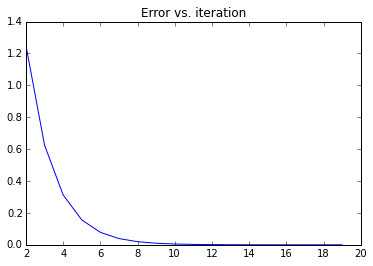

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

xs = []
ys = []
for d in analyzer.get_results():
    xs.append(d['iteration'])
    ys.append(d['error'])

plt.title('Error vs. iteration')
plt.plot(xs, ys)

The analysis gets a snapshot of the system with the checkpointed variables correctly restored. This means that if the parameters of a neural network are checkpointed, the analysis can run the network on validation or testing data.